[IEEE ICMLA 2019](https://www.icmla-conference.org/icmla19/)

[The Data Science landscape: foundations, tools, and practical applications](https://www.icmla-conference.org/icmla19/links/tutorialAM.htm)

# Using data to answer questions

In this part, we will look at the correlation between female literacy and fertility (defined as the average number of children born per woman) throughout the world. For ease of analysis and interpretation, we will work with the illiteracy rate.

This dataset comes from [DataCamp's Statistical Thinking in Python, part 2](https://campus.datacamp.com/courses/statistical-thinking-in-python-part-2/parameter-estimation-by-optimization?ex=6).

Our objective is to check if this hypothesis is correct:

> There is a positive correlation between illiteracy and fertility, i.e. the higher the illiteracy rate, the higher the average number of children born per woman is

We will use [_statistical hypothesis test_](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing) for that:

1. Load and inspect the dataset
1. Prepare the data
1. Check if a correlation exists
1. Test if the correlation is not by chance, i.e. that the hypothesis is correct

# 1. Loading and inspecting the dataset

In [1]:
import pandas as pd

df = pd.read_csv('data/female_literacy_fertility.csv')

In [2]:
df.shape

(162, 5)

In [3]:
df.columns

Index(['Country', 'Continent', 'female literacy', 'fertility', 'population'], dtype='object')

In [4]:
df.head()

,Country,Continent,female literacy,fertility,population
0,Chine,ASI,90.5,1.769,"1,324,655,000"
1,Inde,ASI,50.8,2.682,"1,139,964,932"
2,USA,NAM,99.0,2.077,"304,060,000"
3,Indonésie,ASI,88.8,2.132,"227,345,082"
4,Brésil,LAT,90.2,1.827,"191,971,506"


In [5]:
df.describe()

,female literacy,fertility
count,162.000000,162.000000
mean,80.107407,2.878673
std,23.052415,1.427597
min,12.600000,0.966000
25%,66.425000,1.823250
50%,90.000000,2.367500
75%,98.500000,3.880250
max,100.000000,7.069000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 5 columns):
Country            162 non-null object
Continent          162 non-null object
female literacy    162 non-null float64
fertility          162 non-null float64
population         162 non-null object
dtypes: float64(2), object(3)
memory usage: 6.5+ KB


By inspecting the dataset, we found out that:
    
1. It has 162 entries (`shape`).
1. Each entry seems to represent one country (`head()`). We will check this assumption soon.
1. Each entry has the female literacy rate and average fertility (children born per woman) for that country, plus other fields we are not interested in (`head()` again).
1. There are some low literacy rates (`describe()`). We will check this too soon.
1. The fertility rates seem reasonable (also from `describe()`).
1. There are no missing values in any row or column (`info()`).
1. The representation of each column (number or string) seems correct (also from `info()`).

Let's check the assumption we made in item 2, that there is one entry per country.

In [7]:
print(df.Country.nunique())

162


There are 162 unique countries names, matching the number of rows in the dataset. Therefore, each row is a unique country.

Now let's check the countries with suspiciously low literacy rate.

In [8]:
display(df[df['female literacy'] <= 30])

,Country,Continent,female literacy,fertility,population
15,Ethiopie,AF,22.8,5.211,"80,713,434"
39,Afghanistan,ASI,12.6,6.505,"29,021,099"
60,Burkina Faso,AF,21.6,5.841,"15,233,884"
62,Niger,AF,15.1,7.069,"14,704,318"
66,Mali,AF,18.2,5.405,"12,705,736"
72,Tchad,AF,21.9,6.081,"10,913,667"
79,Guinée,AF,26.4,5.329,"9,833,055"
85,Bénin,AF,28.1,5.378,"8,662,086"
101,Sierra Leone,AF,28.9,5.165,"5,559,853"


These countries are the ones we would expect to have low literacy. The values also match the [World Bank's female literacy dataset, around 2010](https://data.worldbank.org/indicator/SE.ADT.LITR.FE.ZS?end=2010&start=1970).

At this point we understand and trust our data. We can move on to preparing the data, checking for a correlation and testing the hypothesis that the correlation is not by chance.

## 2. Preparing the data

This the statement we want to verify (copied from the first section):

> There is a positive correlation between illiteracy and fertility, i.e. the higher the illiteracy rate, the higher the average number of children born per woman is

We do not need the complete dataset to test the hypothesis. We just need the literacy rate and the fertility number. We will split them out of the dataset.

Since the hypothesis is phrased in terms of _illiteracy_ and the dataset has _literacy_, we will also change the literacy rate to illiteracy rate. This makes writing the code a bit more natural (we don't have to think in terms of a reverse relationship all the time), preventing possible bugs (good data representation reduces [extraneous cognitive load](https://en.wikipedia.org/wiki/Cognitive_load)).

Also, when we present the results to the stakeholders, or even review in details how we got there, the graphs and code will match more closely how the stakeholders phrase (and frame) the statement.

In [9]:
fertility = df['fertility']
illiteracy = 100 - df['female literacy']

In [10]:
print(fertility.head())

0    1.769
1    2.682
2    2.077
3    2.132
4    1.827
Name: fertility, dtype: float64


In [11]:
print(illiteracy.head())

0     9.5
1    49.2
2     1.0
3    11.2
4     9.8
Name: female literacy, dtype: float64


One last adjustment: the series name is still set to `female literacy`, from the original column name. Let's fix that.

In [12]:
illiteracy.name = '% illiterate'
illiteracy.head()

0     9.5
1    49.2
2     1.0
3    11.2
4     9.8
Name: % illiterate, dtype: float64

## 3. Checking if a correlation exists

Before setting out to test the hypothesis, we need to check if a correlation exists in the first place.

We will do it in two ways: a visual inspection first, then a formal measurement of correlation.

### Visualizing a (possible) correlation

Plot illiteracy vs. fertility to see if we can visually spot a correlation.

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Use this line for presentations
#sns.set(context='talk')
# Use this line for online view (e.g. GitHub commits)
sns.set()

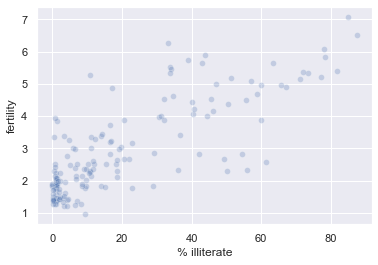

In [14]:
sns.scatterplot(illiteracy, fertility, alpha=0.25);

Note the use of `alpha`. In scatter plots, `alpha` allows us to spot clusters of data, like the one on the bottom left.

We can see a trend in the graph: as illiteracy increases, so does fertility.

### Calculating the correlation coefficient

In [15]:
import numpy as np

empirical_corrcoef = np.corrcoef(illiteracy, fertility)[0, 1]
empirical_corrcoef

0.8041324026815344

This is the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient). A value of 1 (one) indicates a perfect positive correlation. The value calculated for our dataset is close to one, indicating a strong positive correlation (see [table 1 here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6107969/)).

We are calling it the _empirical_ correlation coefficient because it is calculated from the samples collected to create the dataset.

## 4. Testing the hypothesis

So far we have been able to establish that there is a strong positive correlation between illiteracy and fertility.

What we don't know yet is if this correlation is only by chance.

To verify that, we will perform a [_statistical hypothesis test_](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing). Our null hypothesis is the opposite of the statement we want to verify:

> The fertility of a given country is totally independent of its illiteracy.

To verify the null hypothesis, we will:

1. Run a large number of permutations of the illiteracy rates from the dataset, while keeping the fertility rates unchanged. For each permutation, calculate the correlation coefficient.
1. Calculate how many of these permutations resulted in a correlation coefficient larger than the correlation coefficient from the original dataset, the empirical correlation coefficient.

What we are looking for: 

- If we find a large number of permutations with correlation coefficients similar to the empirical coefficient, it means the empirical coefficient occurred by chance.
- If, on the other hand, we find a very small number of permutations with a correlation coefficient similar to the empirical coefficient, we can reasonably assume that the empirical coefficient did _not_ occur by chance and, therefore, there is a correlation between illiteracy and fertility.

### Step 1: run a large number of experiments

In [16]:
%%time
# This may take a while to run
# Print the time to give the readers an idea of how long it will take

# To make it reproducible
np.random.seed(42)

# The number of experiments we will run
N = 100_000

# Stores the correlation coefficients from each replication (experiment)
permutated_corrcoeff = np.empty(N)

for i in range(N):
    # Generate a permutation of the illiteracy values
    permutated = np.random.permutation(illiteracy)
    
    # Calculate the correlation coefficient between this permutation
    # and the countries (always the same list of countries)
    permutated_corrcoeff[i] = np.corrcoef(permutated, fertility)[0, 1]

CPU times: user 22.9 s, sys: 139 ms, total: 23 s
Wall time: 23.4 s


### Step 2: calculate how many experiments are above the empirical coefficient

In [17]:
experiments_above_empirical = np.sum(permutated_corrcoeff > empirical_corrcoef)

### Analyzing the results

We will analyze the results in terms of the [p-value](https://en.wikipedia.org/wiki/P-value): the fraction of experiments whose correlation coefficients are greater than the one observed in the dataset (the empirical correlation coefficient).

In [18]:
p_value = experiments_above_empirical / N

In [19]:
print('The empirical correlation coefficient = {}'.format(empirical_corrcoef))
print('The largest experimental correlation coefficient = {}'.format
      (np.max(permutated_corrcoeff)))
print('Out of {:,} simulations, {} are > the empirical coefficient'.\
     format(N, experiments_above_empirical))
print('p-value = {:f}'.format(p_value))

The empirical correlation coefficient = 0.8041324026815344
The largest experimental correlation coefficient = 0.33804022121150534
Out of 100,000 simulations, 0 are > the empirical coefficient
p-value = 0.000000


The p-value we calculated is < 10<sup>-5</sup> (We ran only 100,000 of the possible experiments. The number of possible experiments is the number of possible permutations, a very large number. We do not know what would happen if we ran more experiments. Therefore, all we can say is that the p-value is less than the resolution of our experiments, 10<sup>-5</sup>).

Given the low p-value, it is unlikely that the null hypothesis is true. Therefore, we reject the null hypothesis and conclude that the relationship between fertility and illiteracy is unlikely to have occurred by chance. In other words, there is indeed a positive correlation between illiteracy and fertility.

## Summary

We simulated illiteracy rates with `np.random.permutation()` to test our hypothesis and found that only a small number of experiments had a correlation coefficient higher than the one we calculated with the dataset (the empirical value). That value is so small that we were not even able to measure it with our experiments (all we can say is that it is less than 10<sup>-5</sup>).

To get to that point, we:

- Inspected the dataset with `shape`, `columns`, `describe()`, and `info()`
- Checked for possible duplicated entries (duplicated countries) with `nunique()`.
- Performed a domain check (the suspiciously low literacy rates), to verify if the data make sense. We found out that it matches a reliable source.
- To make the code clearer, we split out of the dataset only the pieces of information we need and transformed some pieces of data into a more convenient format (`fertility` and `illiteracy`).
- Established that there is a correlation visually (with a scatter plot) and formally (with the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)).
- Once we confirmed that there is a correlation, we performed a large number of experiments to check if the correlation exists by chance (with `np.random.permutation()`).
- To make our experiments reproducible, we set a seed for the pseudorandom generator (`np.random.seed(42)`).